<a href="https://colab.research.google.com/github/osmaanural/GAN-BreastCancer-DataAug/blob/main/BreastCancer_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader  # veri yüklemek için
import torchvision.utils as utils  ##görselleştirme için
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision


#GAN İLE VERİ ARTTIRMA

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CancerOnlyDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Tek kanal için "L"
        if self.transform:
            image = self.transform(image)
        label = 1  # Tüm görüntüler kanserli olduğu için etiket 1
        return image, label


In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),  # X-ray’ler genelde tek kanallı
    transforms.ToTensor(),                # [0, 255] → [0, 1]
    transforms.Normalize([0.5], [0.5])    # [0, 1] → [-1, 1]
])


In [7]:
image_size=256*256

In [8]:
dataset_path="/content/drive/MyDrive/Colab Notebooks/train/Cancer"

In [9]:
len(train_Datasets)

NameError: name 'train_Datasets' is not defined

In [10]:
train_Datasets=CancerOnlyDataset(image_dir=dataset_path, transform=transform)

In [11]:
dataloader=DataLoader(train_Datasets,batch_size=8,shuffle=True)

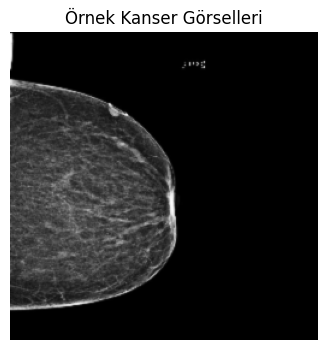

In [12]:
import matplotlib.pyplot as plt

# İlk batch'ten birkaç görsel gösterelim
images, labels = next(iter(dataloader))
grid_img = torchvision.utils.make_grid(images[:1], nrow=1, normalize=True)
plt.figure(figsize=(8, 4))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title("Örnek Kanser Görselleri")
plt.show()


In [13]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),     # 256 → 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),   # 128 → 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 64 → 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # 8 → 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 1, kernel_size=4),             # 4 → 1
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        return out.view(-1, 1)


In [14]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512 * 4 * 4),     # Başlangıç: 4x4
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4 → 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8 → 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16 → 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 32 → 64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 64 → 128
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 1, 4, 2, 1),     # 128 → 256
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [15]:

lr=0.0001
epochs=200
generator=Generator().to(device)
discriminatör=Discriminator().to(device)

criterion=nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminatör.parameters(), lr=0.00005, betas=(0.5, 0.999))


In [16]:
import os
import torch
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Klasör oluştur
os.makedirs("/content/drive/MyDrive/augfinally_ssim", exist_ok=True)

# SSIM hesaplama fonksiyonu
def calculate_ssim(img1, img2):
    img1 = to_pil_image(img1)
    img2 = to_pil_image(img2)
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, data_range=img2.max() - img2.min())

g_loss_list = []
d_loss_list = []
epoch_ssim_scores = []

for epoch in range(epochs):
    for i, (real_img, _) in enumerate(dataloader):
        real_img = real_img.to(device)
        batch_size = real_img.size(0)

        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        noise = torch.randn(batch_size, 100).to(device)
        fake_img = generator(noise)

        # Discriminator
        real_loss = criterion(discriminatör(real_img), real_labels)
        fake_loss = criterion(discriminatör(fake_img.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator
        g_loss = criterion(discriminatör(fake_img), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    d_loss_list.append(d_loss.item())
    g_loss_list.append(g_loss.item())

    # === SSIM hesapla ===
    with torch.no_grad():
        test_noise = torch.randn(1, 100).to(device)
        fake_images = generator(test_noise).cpu()

        # Gerçek görüntülerden örnek al
        real_images_sample = next(iter(dataloader))[0][:len(fake_images)].cpu()

        # Ortak sayıda görüntü için SSIM
        num_compare = min(len(fake_images), len(real_images_sample))
        ssim_scores = [
            calculate_ssim(fake_images[i], real_images_sample[i])
            for i in range(num_compare)
        ]
        mean_ssim = sum(ssim_scores) / len(ssim_scores)
        epoch_ssim_scores.append((epoch + 1, mean_ssim))

    print(f"Epoch {epoch+1}/{epochs} | d_loss: {d_loss.item():.3f} | g_loss: {g_loss.item():.3f} | SSIM: {mean_ssim:.4f}")

# ✅ En yüksek SSIM'e sahip epoch'u bul
best_epoch, best_ssim = sorted(epoch_ssim_scores, key=lambda x: x[1], reverse=True)[0]
print(f"\n✅ En yüksek SSIM skoru {best_ssim:.4f} ile epoch {best_epoch}")

# ✅ En iyi epoch için sahte görüntü üret ve kaydet
with torch.no_grad():
    best_noise = torch.randn(300,100).to(device)
    best_fake_images = generator(best_noise).cpu()

    best_dir = os.path.join("/content/drive/MyDrive/augfinally_ssim2", f"epoch_{best_epoch}")
    os.makedirs(best_dir, exist_ok=True)

    for idx, img in enumerate(best_fake_images):
        save_path = os.path.join(best_dir, f"img_{idx+1:02d}.jpg")
        save_image(img, save_path, normalize=True)

    print(f">>> En iyi epoch ({best_epoch}) için 50 sahte görüntü '{best_dir}' klasörüne kaydedildi.")


Epoch 1/200 | d_loss: 0.393 | g_loss: 3.650 | SSIM: 0.0023
Epoch 2/200 | d_loss: 0.396 | g_loss: 3.555 | SSIM: 0.0020
Epoch 3/200 | d_loss: 0.351 | g_loss: 4.024 | SSIM: 0.0033
Epoch 4/200 | d_loss: 0.623 | g_loss: 2.735 | SSIM: 0.0133
Epoch 5/200 | d_loss: 0.447 | g_loss: 4.356 | SSIM: 0.0102
Epoch 6/200 | d_loss: 0.647 | g_loss: 2.626 | SSIM: 0.0259
Epoch 7/200 | d_loss: 0.461 | g_loss: 5.234 | SSIM: 0.0309
Epoch 8/200 | d_loss: 0.867 | g_loss: 1.389 | SSIM: 0.1071
Epoch 9/200 | d_loss: 0.539 | g_loss: 3.081 | SSIM: 0.0642
Epoch 10/200 | d_loss: 0.456 | g_loss: 5.237 | SSIM: 0.0940
Epoch 11/200 | d_loss: 0.430 | g_loss: 3.645 | SSIM: 0.1267
Epoch 12/200 | d_loss: 0.801 | g_loss: 3.763 | SSIM: 0.1232
Epoch 13/200 | d_loss: 0.399 | g_loss: 2.195 | SSIM: 0.0787
Epoch 14/200 | d_loss: 0.436 | g_loss: 2.193 | SSIM: 0.0341
Epoch 15/200 | d_loss: 0.331 | g_loss: 4.372 | SSIM: 0.2076
Epoch 16/200 | d_loss: 0.461 | g_loss: 6.350 | SSIM: 0.0670
Epoch 17/200 | d_loss: 0.391 | g_loss: 3.900 | SS

# SINIFLANDIRMA


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.utils as vutils


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [16]:

def data_loader(batch_size=32):
  transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 1 kanal
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])


  # Veri Ayırma-train-test şeklinde
  train_datasets=datasets.ImageFolder(root='/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/train',transform=transform)
  test_datasets=datasets.ImageFolder(root='/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/train',transform=transform)


  # Veri Yükleme
  train_loader=DataLoader(train_datasets,batch_size=32,shuffle=True)
  test_loader=DataLoader(test_datasets,batch_size=32,shuffle=False)

  return train_loader,test_loader

train_loader,test_loader=data_loader()

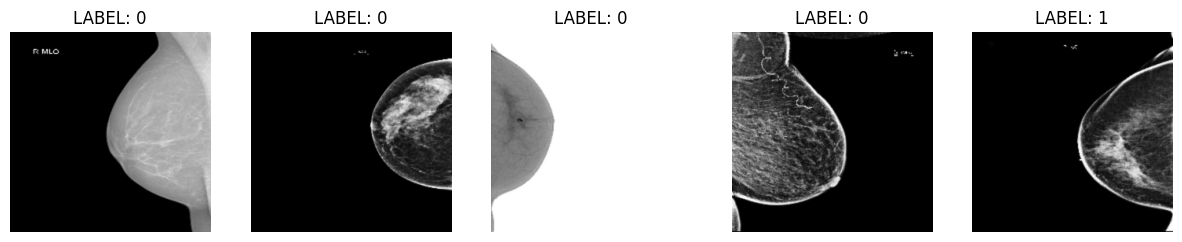

In [17]:
# 1. Görüntü gösterme fonksiyonu
def imshow(img):
    img = img / 2 + 0.5  # normalize düzeltmesi ([-1,1] -> [0,1])
    np_img = img.numpy()
    plt.imshow(np_img.squeeze(0), cmap="gray")

# 3. Train loader'dan bir batch çekme
def get_sample_images(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

# 4. Görselleştirme fonksiyonu
def visualize(n=5):
    train_loader, test_loader =data_loader()
    images, labels = get_sample_images(train_loader)

    plt.figure(figsize=(n * 3, 3))  # Görsel boyutu: n*3 genişlik
    for i in range(n):
        plt.subplot(1, n, i + 1)
        imshow(images[i])
        plt.title(f"LABEL: {labels[i].item()}")
        plt.axis("off")
    plt.show()
visualize()

In [18]:
## Modelin Oluşturulması

class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(1,16,3,padding=1)   #256--> 128
    self.relu=nn.ReLU()
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(16,32,3,padding=1)   # 128--> 64
    self.conv3=nn.Conv2d(32,64,3,padding=1)   # 64--> 32
    # self.conv4=nn.Conv2d(64,128,3,padding=1)  # 32--> 16
    self.bn1=nn.BatchNorm2d(16)
    self.dropout=nn.Dropout(0.25)
    self.fc1=nn.Linear(64*32*32,128)
    self.fc2=nn.Linear(128,2)

  def forward(self,x):
    x=self.conv1(x)  ## 16,256,256
    x=self.relu(x)
    x=self.pool(x)   ## 256--> 128
    x=self.bn1(x)
    # x=self.dropout(x)

    x=self.conv2(x)  ## 32,128,128
    x=self.relu(x)
    x=self.pool(x)   ## 128--> 64

    # x=self.dropout(x)

    x=self.conv3(x)  ## 64,64,64
    x=self.relu(x)
    x=self.pool(x)   ## 64 --> 32

    x=self.dropout(x)

    # x=self.conv4(x)  ## 128,32,32
    # x=self.relu(x)
    # x=self.pool(x)   ## 32--> 16
    # # x=self.dropout(x)

    x=x.view((x.size(0)),-1) ##düzleştirmek için 128,16,16  vekötr haline getirildi.
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)

    return x




In [19]:
## Call Back Tanımlanması
class EarlyStopping:
  def __init__(self,patience=5,min_delta=0.00001):
    self.patience=patience
    self.min_delta=min_delta
    self.counter=0
    self.best_loss=None

  def __call__(self,loss):
    if self.best_loss is None or loss>self.best_loss-self.min_delta:
      self.best_loss=loss
      self.counter=0
    else:
      self.counter+=1
    if self.counter>=self.patience:
      return True
    return False



In [20]:
## Model Eğitimi
epochs=100
lr=0.0001
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model=CNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
early_stopping=EarlyStopping(patience=3,min_delta=0.00001)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def training(model, train_loader, optimizer, criterion, epochs, device):
    model = model.to(device)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Sınıf tahminlerini al
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Metrikleri hesapla
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        # if early_stopping(avg_loss):
        #     print(f"⏹️ Early stopping activated at epoch {epoch+1}")
        #     break

    # Loss grafiği
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, linestyle="--", label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()
    plt.show()


Epoch 1/50 | Loss: 0.631957 | Acc: 0.6490 | Precision: 0.6348 | Recall: 0.6078 | F1: 0.6052
Epoch 2/50 | Loss: 0.552154 | Acc: 0.7270 | Precision: 0.7347 | Recall: 0.6894 | F1: 0.6938
Epoch 3/50 | Loss: 0.509597 | Acc: 0.7588 | Precision: 0.7676 | Recall: 0.7265 | F1: 0.7335
Epoch 4/50 | Loss: 0.461646 | Acc: 0.7766 | Precision: 0.7925 | Recall: 0.7434 | F1: 0.7518
Epoch 5/50 | Loss: 0.416720 | Acc: 0.8179 | Precision: 0.8317 | Recall: 0.7915 | F1: 0.8012
Epoch 6/50 | Loss: 0.359736 | Acc: 0.8440 | Precision: 0.8565 | Recall: 0.8214 | F1: 0.8313
Epoch 7/50 | Loss: 0.307917 | Acc: 0.8788 | Precision: 0.8918 | Recall: 0.8598 | F1: 0.8698
Epoch 8/50 | Loss: 0.281135 | Acc: 0.8781 | Precision: 0.8857 | Recall: 0.8619 | F1: 0.8701
Epoch 9/50 | Loss: 0.228412 | Acc: 0.9156 | Precision: 0.9214 | Recall: 0.9041 | F1: 0.9108
Epoch 10/50 | Loss: 0.211616 | Acc: 0.9167 | Precision: 0.9196 | Recall: 0.9074 | F1: 0.9125
Epoch 11/50 | Loss: 0.169442 | Acc: 0.9345 | Precision: 0.9385 | Recall: 0.9260

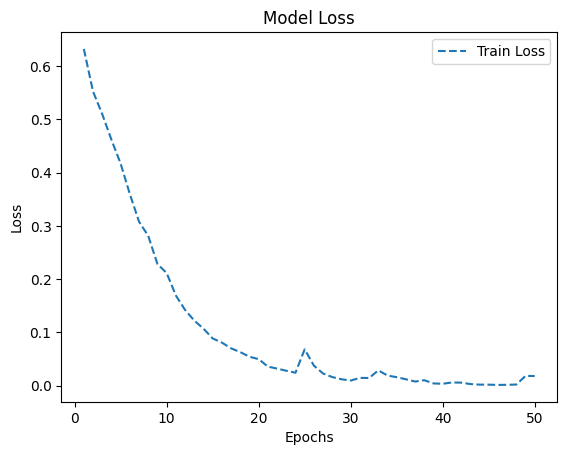

In [23]:
 training(model,train_loader,optimizer,criterion,epochs=50,device=device)

In [25]:
torch.save(model,"ganmodel.pt")

Test Accuracy: 99.85%
Precision: 1.00
Recall:    1.00
F1 Score:  1.00


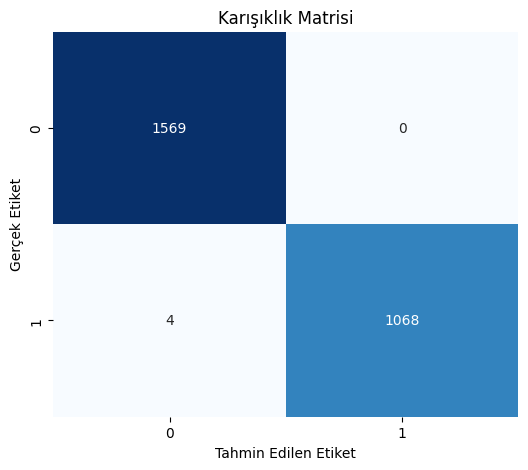

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
model.to(device)
model.eval()
correct = 0
total = 0
all_pred = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 🔢 Doğruluk ve diğer metrikler
print(f"Test Accuracy: {100 * correct / total:.2f}%")

precision = precision_score(all_labels, all_pred, average="macro", zero_division=0)
recall = recall_score(all_labels, all_pred, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_pred, average="macro", zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# 📊 Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(all_labels, all_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karışıklık Matrisi")
plt.show()
